In [1]:
wd <- dirname(dirname(getwd()))
source(paste0(wd,"/mission_control/treasure_map.R"))

library(survival)
library(tidyverse)
library(RColorBrewer)
library(gridExtra)
library(ggpubr)

Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.6
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.1
Warning message:
“package ‘tibble’ was built under R version 3.6.3”Warning message:
“package ‘tidyr’ was built under R version 3.6.3”Warning message:
“package ‘purrr’ was built under R version 3.6.3”Warning message:
“package ‘dplyr’ was built under R version 3.6.3”Warning message:
“package ‘forcats’ was built under R version 3.6.3”── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() 

### 0 - Read in multivariate models output

In [2]:
go <- readRDS(paste0(TMP_DIR, "forest-ready.Rds"))  %>% filter(clean_feature != "Purity")

### 1 - Plot Settings

In [3]:
base_theme <- theme_classic(base_size = 21) 

theme <- (
    base_theme + 
    theme(
        axis.title.y=element_blank(), 
        plot.title = element_text(hjust = 0.5, size =25),#, size = 21),
        legend.position="none"
    )
)

In [4]:
my_palette <- brewer.pal(6,"RdYlGn")[c(1,6)]

In [5]:
color_map <- list(
    "yes" = my_palette[2],
    "no" = my_palette[1],
    "non" = "grey"
)
alpha_map <- list(
    "strong" = 1,
    "moderate" = 1,
    "weak" = .4,
    "non" = .8
)
feature_color_map <- list(
    "TMB" = '#80B1D3',
    "T-cell" = '#FB8072',
    "TGFB" = "#BEBADA",
    "Proliferation" = "#8DD3C7",
    "Pretreatment" = "#9E7788"
)

### 2 - Make Forest plots

In [6]:
plot_maker <- function( df, title = "HMF CPCT Study", study = "clean_study2" ){
    
    if( study == "clean_study"){
        df <- df %>% filter( sets == "clusters")
    }
    
    ggplot( df,  
        aes_string(x = study, 
            y= "est", 
            ymin= "ci_low", 
            ymax= "ci_high", 
            linetype = "sets",
            color = "better", 
            alpha = "z_group")
      ) +
    geom_pointrange(lwd = 1.2) + 
    geom_hline(yintercept=0, lty=2, col = "grey") + 
    coord_flip() +  
    facet_grid( rows = vars(clean_feature), cols = vars(clean_model), scales = "free") + 
    scale_color_manual(values = unlist(color_map)) +
    scale_alpha_manual(values = unlist(alpha_map)) +
    scale_y_continuous(n.breaks = 4 )  +
    ggtitle(title) + 
    ylab("Coefficient Estimate (95% CI)") + 
    theme  
}

- Make separate plots for CPCT and non-CPCT

In [7]:
save_the_forests <- list()

In [8]:
for (i in c("multi", "single")){
    ready <- if( i == "multi"){ go %>% filter(features == "all" )} else {go %>% filter(features != "all" )}
    for( j in c("clean_study", "clean_study2")){
        save_the_forests[[i]][[j]][['cpct']] <- (
            plot_maker( ready %>% filter( grepl("CPCT", cohort) ),  title = "HMF CPI", study = j))
        save_the_forests[[i]][[j]][['external']] <- (
            plot_maker( ready %>% filter( ! grepl("CPCT", cohort) ),  title = "Validation Cohorts", study = j))
    }
}

In [9]:
saveRDS( save_the_forests, paste0(FIG_DIR, "figure4-and-supplement-forest-plots.Rds"))

##### Add color to strips

In [10]:
color_strips <- function(gg){
  g <- ggplot_gtable(ggplot_build(gg))
  strips <- which(grepl('strip', g$layout$name))
  pal <- c("white", "white",unlist(feature_color_map))
  for (i in seq_along(strips)) {
    k <- which(grepl('rect', g$grobs[[strips[i]]]$grobs[[1]]$childrenOrder))
    g$grobs[[strips[i]]]$grobs[[1]]$children[[k]]$gp$fill <- pal[i] 
  } 
  as_ggplot(g)
}

### 3 - Let's see it together!

In [11]:
layout_matrix = rbind(c(rep(1,11), rep(2,12)))

In [12]:
plot_together <- function( p1, p2, layout = layout_matrix, title ){
    step1 <- as_ggplot(
        arrangeGrob(color_strips(p1) + theme(plot.margin = margin(0,1,0,1, "cm")), 
                    color_strips(p2) + theme(plot.margin = margin(0,1,0,1, "cm"))
    , layout_matrix = layout_matrix))
    
    ready <- ( step1 
        + theme(plot.margin = margin(0,0,0,0, "cm"), plot.title = element_text(hjust = 0.5, size =25)) 
        + ggtitle(title)
    )
    ready
}

### 4 - View and send them!

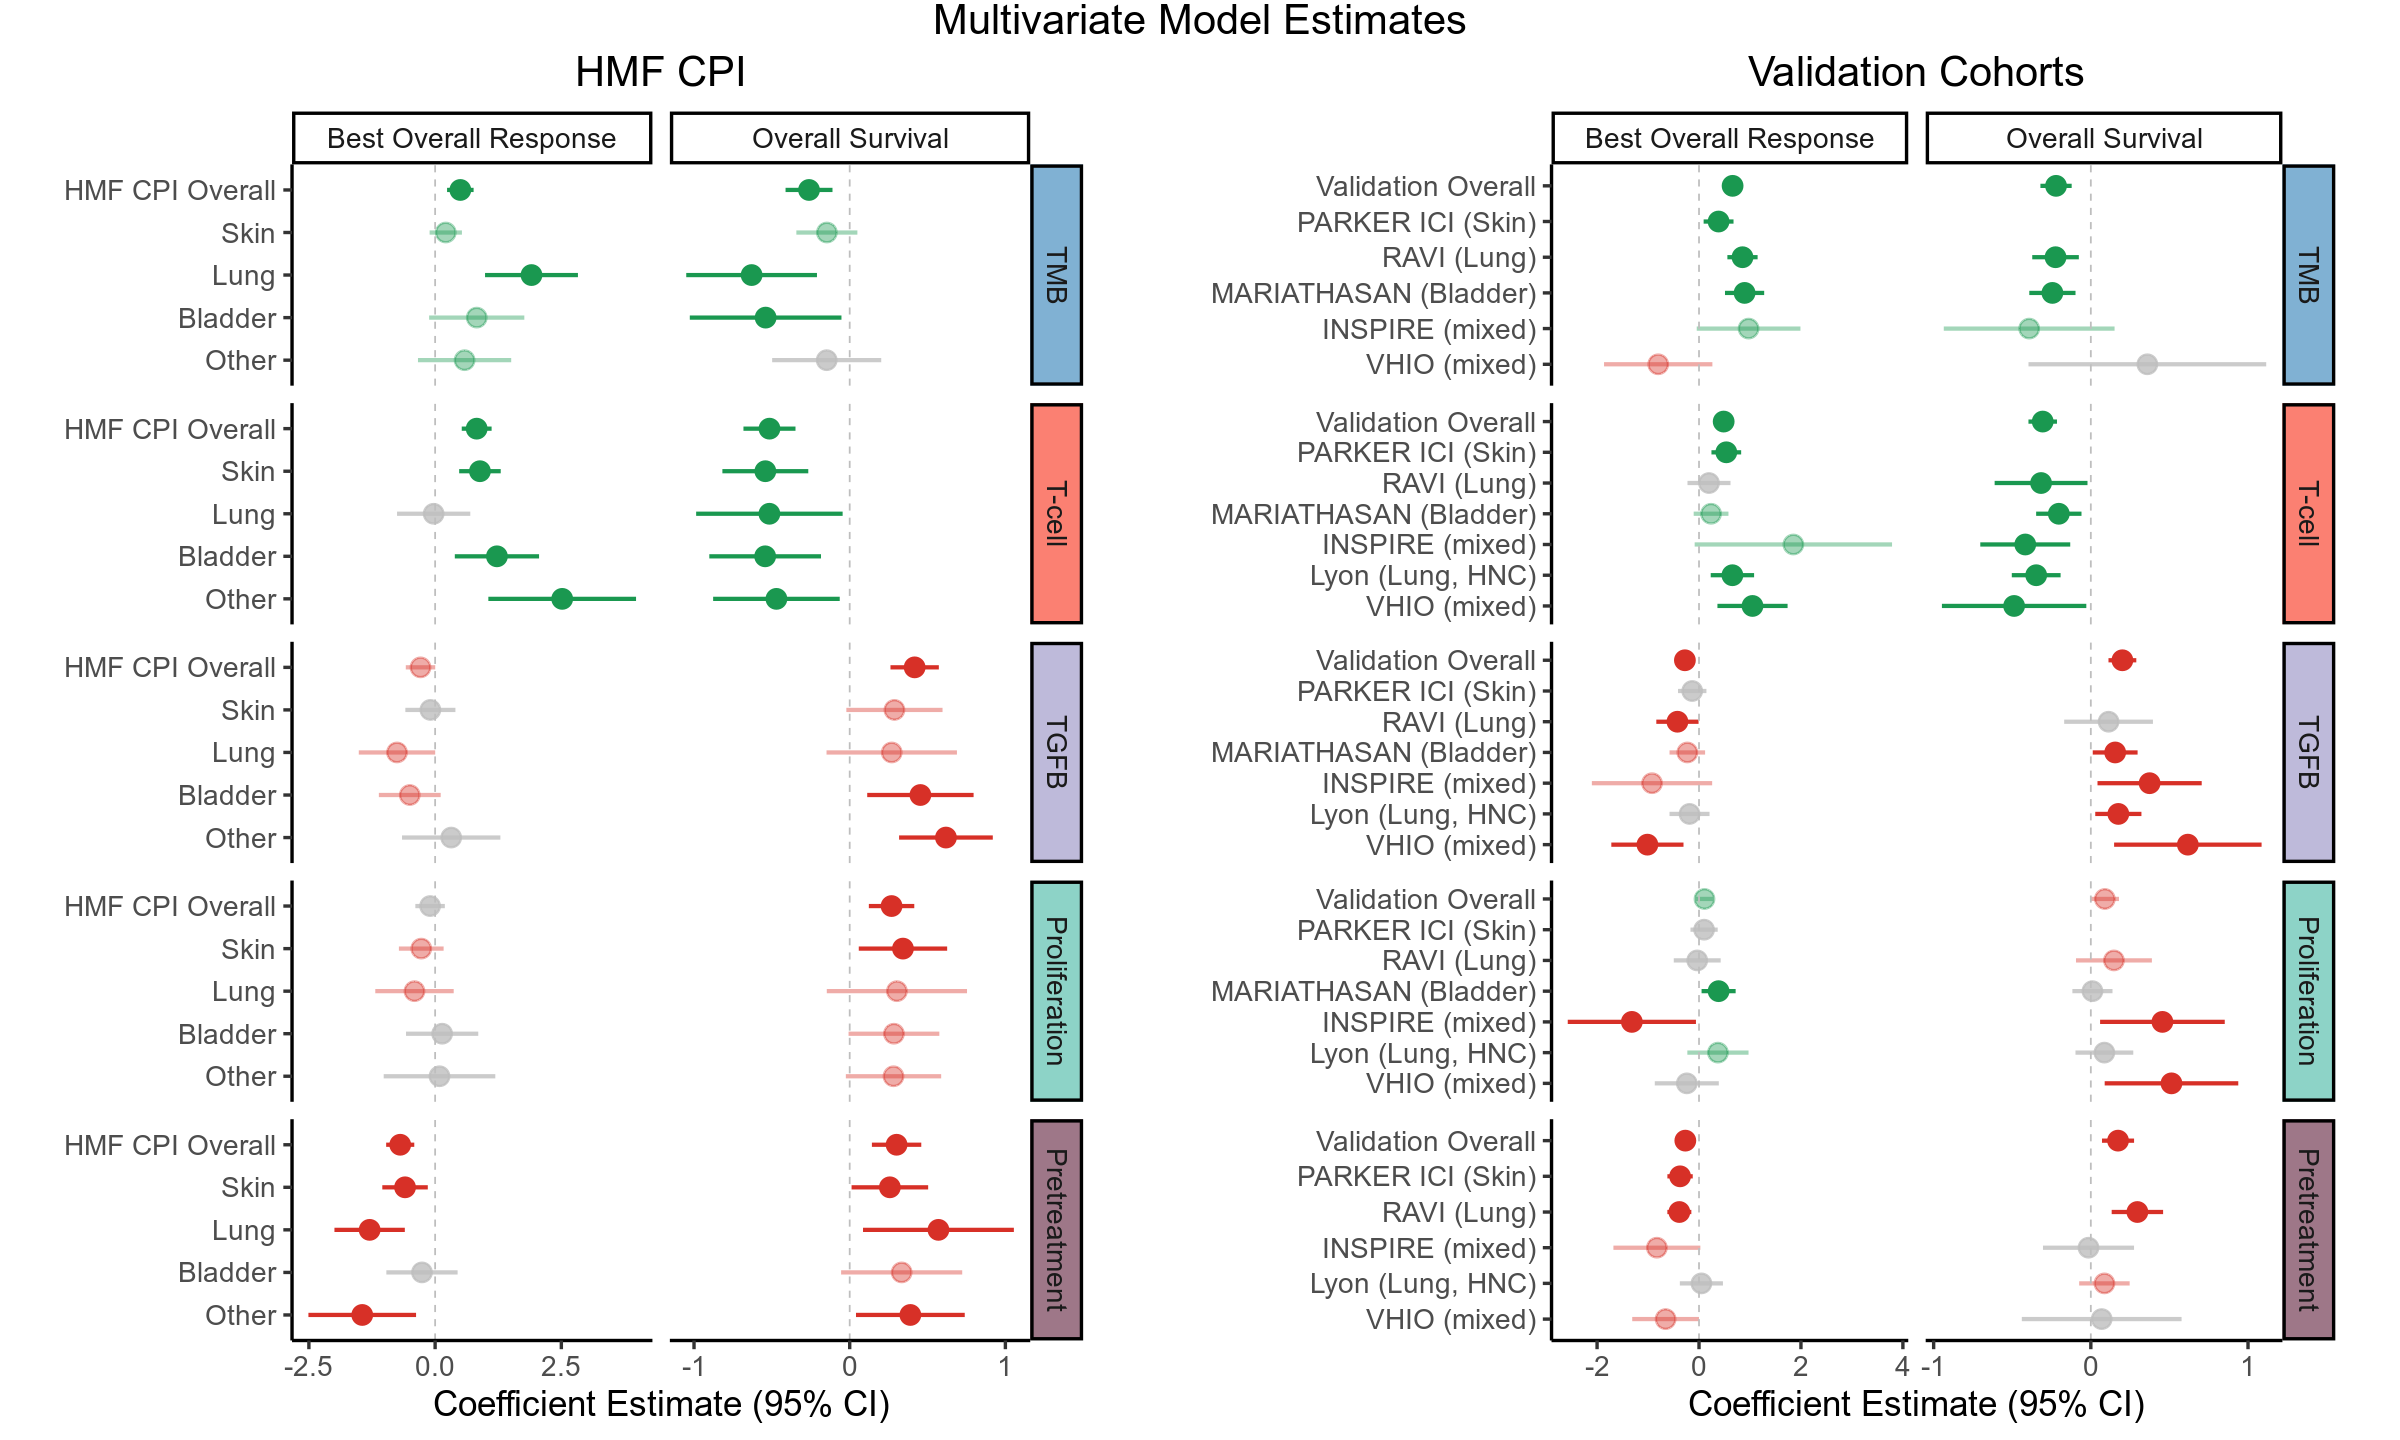

In [13]:
options(repr.plot.width = 20, repr.plot.height= 12, resolution = 200)
figure4 <- plot_together( save_the_forests$multi$clean_study$cpct, save_the_forests$multi$clean_study$external,
               title = "Multivariate Model Estimates")
figure4
ggsave( paste0(FIG_FINAL_DIR, "figure4.png"), width = 20, height = 12)

In [14]:
#FIG_FINAL_DIR

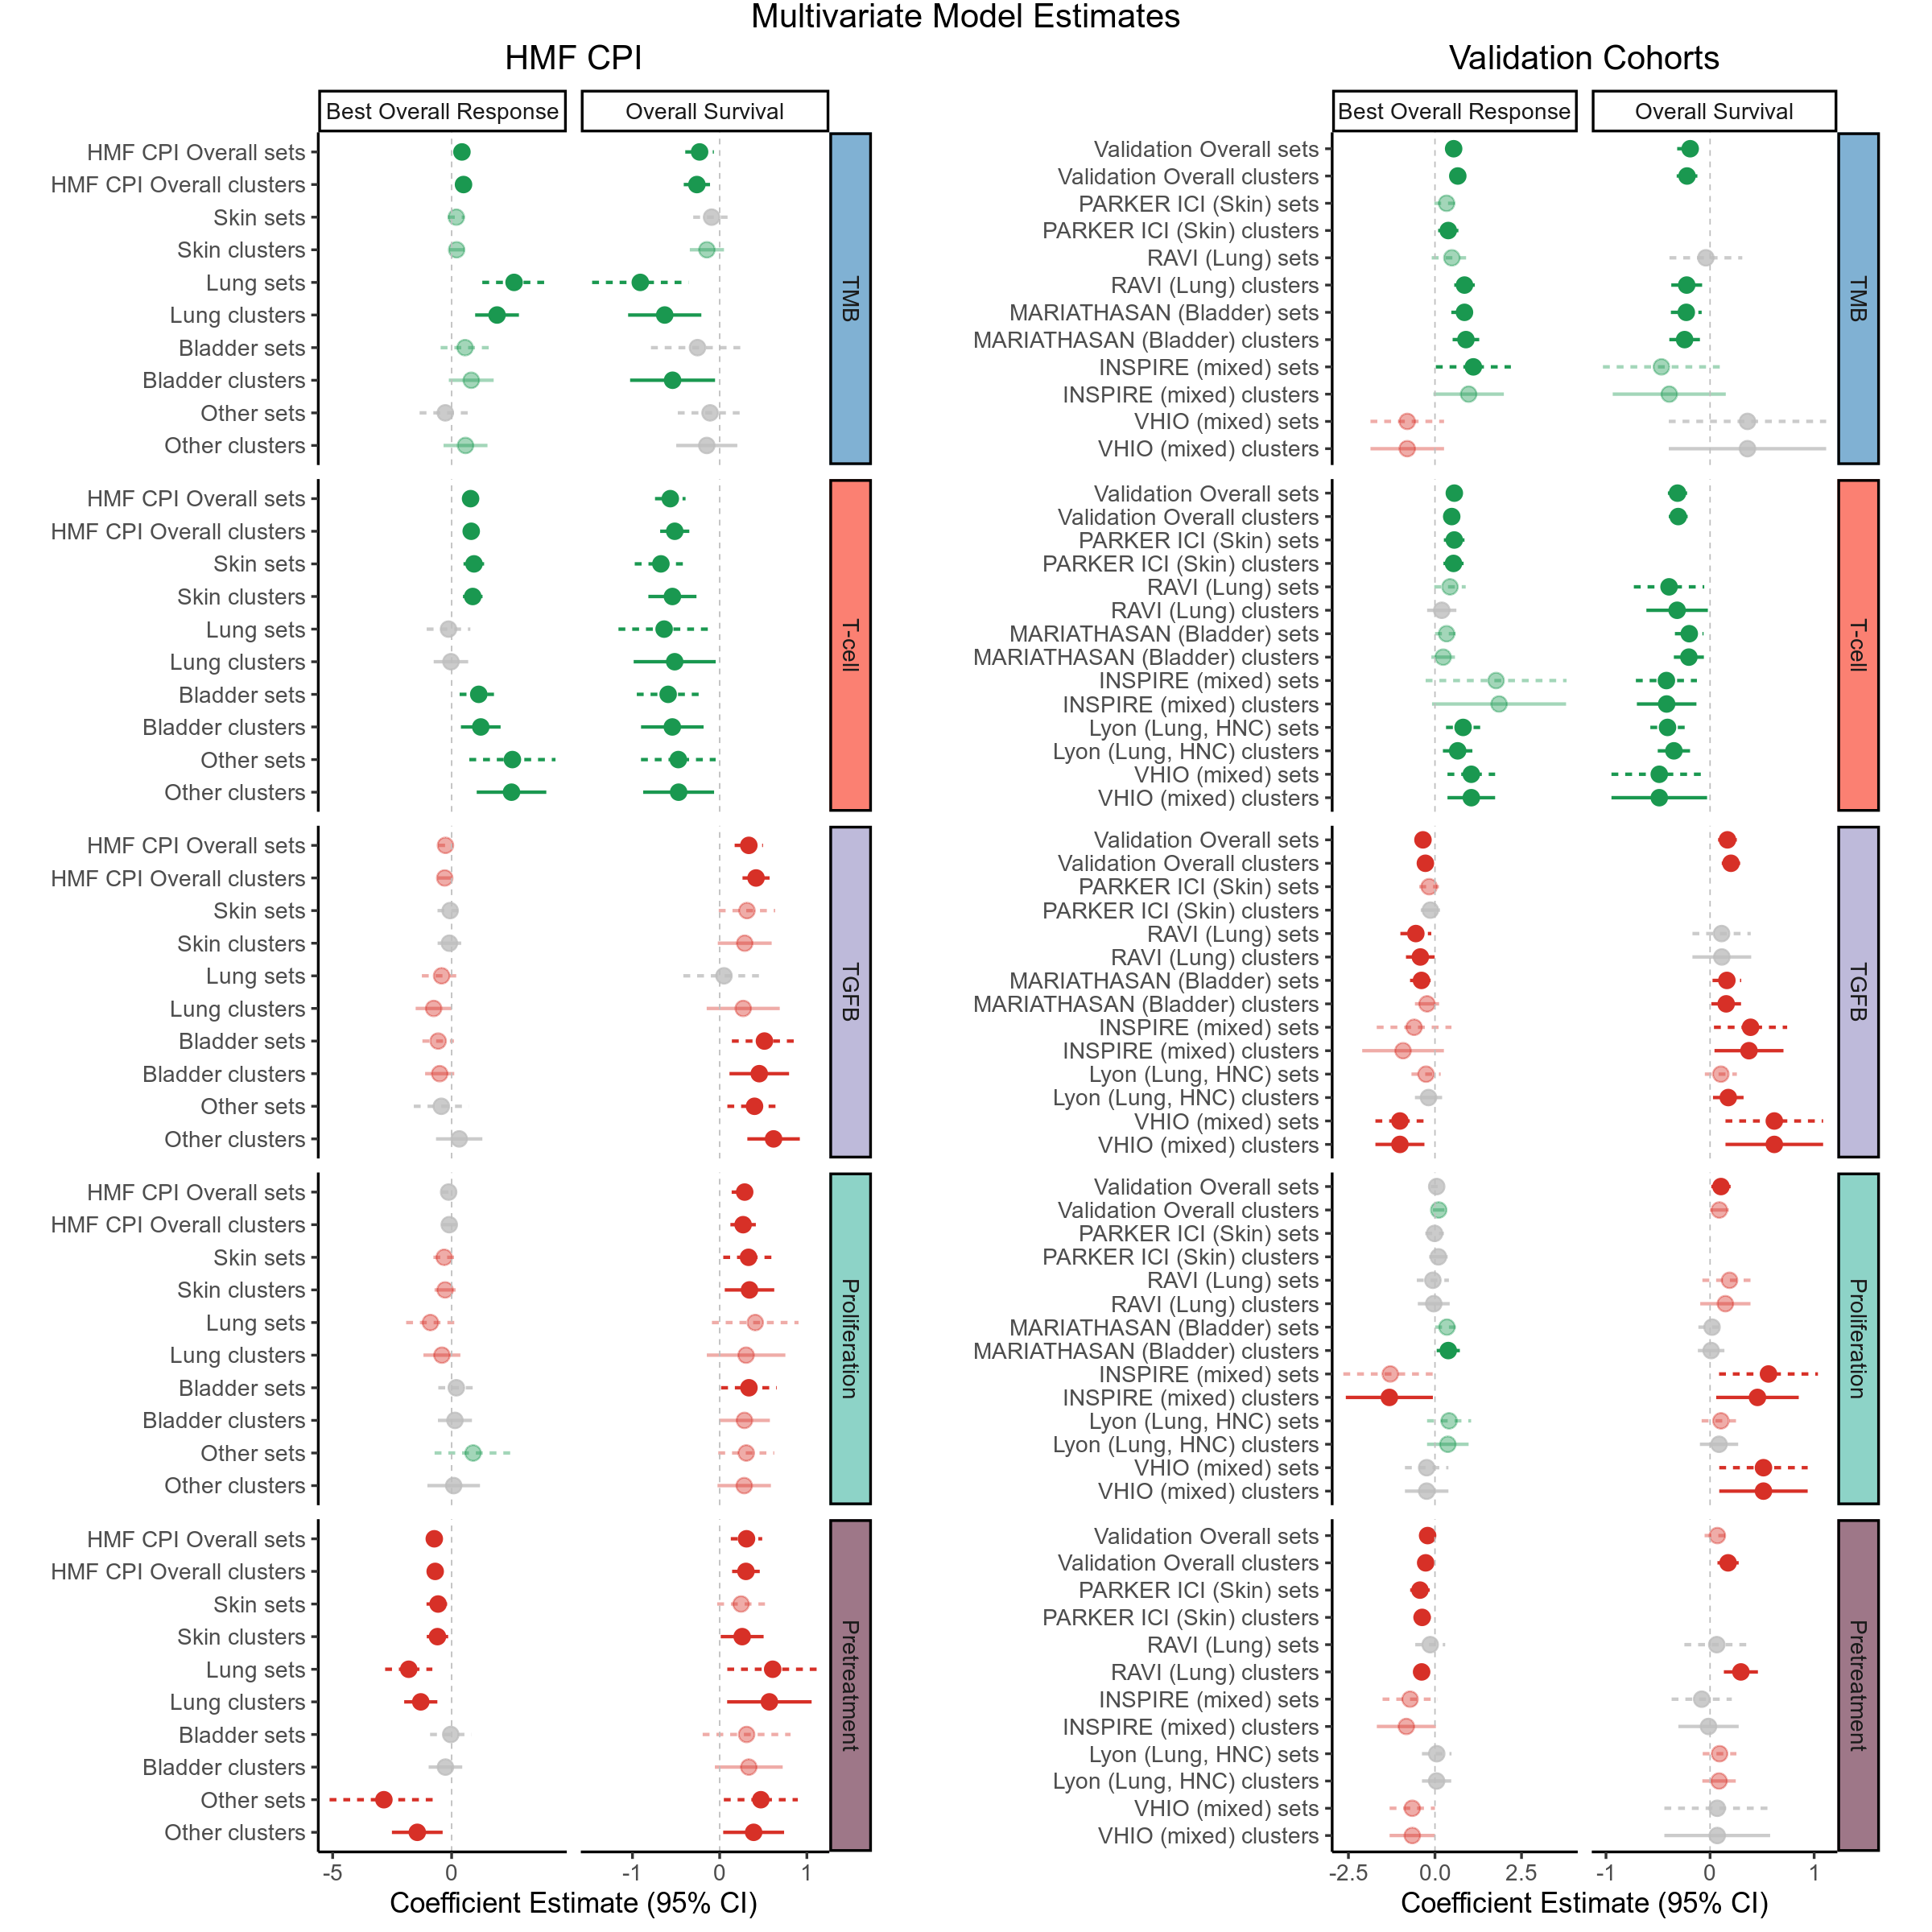

In [15]:
options(repr.plot.width = 20, repr.plot.height= 20, resolution = 200)
plot_together( save_the_forests$multi$clean_study2$cpct, 
               save_the_forests$multi$clean_study2$external, 
               title = "Multivariate Model Estimates")
ggsave( paste0(FIG_FINAL_DIR, "7_forest_plot_sets_clusters.png"), width = 20, height = 20)

In [16]:
options(repr.plot.width = 20, repr.plot.height= 12, resolution = 200)
forest_uni <- plot_together( save_the_forests$single$clean_study$cpct, 
               save_the_forests$single$clean_study$external, 
               title = "Univariate Model Estimates")
saveRDS( forest_uni, paste0(FIG_DIR, "supplement_forest_univariate.Rds"))
#ggsave( paste0(FIG_FINAL_DIR, "7_forest_plot_supp_univariate.png"), width = 20, height = 12)

Warning message:
“Removed 2 rows containing missing values (geom_pointrange).”